## Give credit to Notebook: 
[Basic EDA, Cleaning and Glove][1].

**Great introduction for Nature language processing!**

[1]: https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove

## Import libries and load datasets

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import pandas as pd
import re
import seaborn as sns
import string
from tqdm import tqdm
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df['target']

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

## Have a first look at the tweet dataset

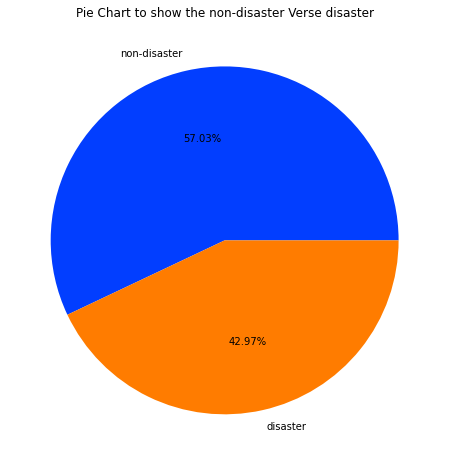

In [4]:
# create pie chart for our labels data
plt.figure(figsize = [8,8])
colors = sns.color_palette('bright')
plt.pie(train_df.target.value_counts(), labels = ['non-disaster', 'disaster'], colors = colors, autopct='%1.2f%%')
plt.title('Pie Chart to show the non-disaster Verse disaster')

plt.show()

Note that we have more non-disaster tweets than disaster tweets in our training dataset

### understand the distribution of the chars/ words counts for the datase

**find out how many characters in each tweets**

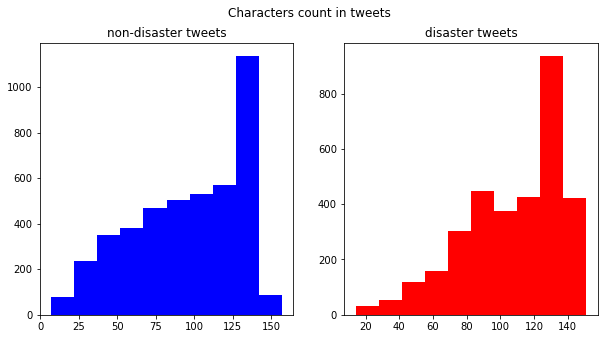

In [5]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize = (10,5))
nondisaster_tweets_len = train_df[train_df['target']==0]['text'].str.len()
ax1.hist(nondisaster_tweets_len, color = 'blue')
ax1.set_title('non-disaster tweets')

disaster_tweets_len = train_df[train_df['target']==1]['text'].str.len()
ax2.hist(disaster_tweets_len, color = 'red')
ax2.set_title('disaster tweets')

fig.suptitle('Characters count in tweets')
plt.show()

**find out how many words are used in each tweet**

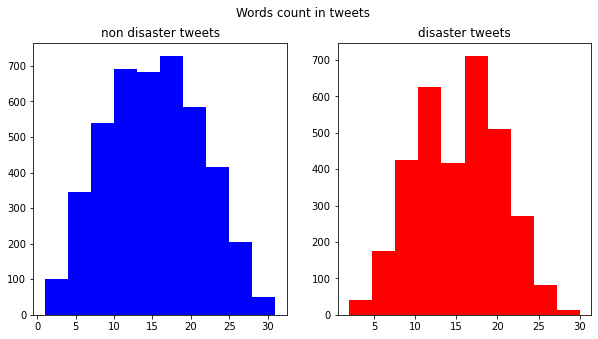

Non-disaster dataset:
       words count
count  4342.000000
mean     14.704744
std       6.161564
min       1.000000
25%      10.000000
50%      15.000000
75%      19.000000
max      31.000000
disaster dataset:
       words count
count  3271.000000
mean     15.167533
std       5.096806
min       2.000000
25%      11.000000
50%      15.000000
75%      19.000000
max      30.000000


In [6]:
word_count0 = []
word_count1 = []
non_disaster_tweets = train_df[train_df['target'] == 0]['text'].values
disaster_tweets = train_df[train_df['target'] == 1]['text'].values
for i in range(non_disaster_tweets.shape[0]):
    cur_wordcount = len(non_disaster_tweets[i].split())
    word_count0.append(cur_wordcount)
for i in range(disaster_tweets.shape[0]):
    cur_wordcount = len(disaster_tweets[i].split())
    word_count1.append(cur_wordcount)

fig, (ax1, ax2)=plt.subplots(1,2,figsize = (10,5))
ax1.hist(word_count0, color = 'blue')
ax1.set_title('non disaster tweets')

notdisaster_tweets_len = train_df[train_df['target']==0]['text'].str.len()
ax2.hist(word_count1, color = 'red')
ax2.set_title('disaster tweets')

fig.suptitle('Words count in tweets')
plt.show()

## have some statistic info for non-disaster and disaster dataset
df1 = pd.DataFrame (word_count0, columns = ['words count'])
print('Non-disaster dataset:')
print(df1.describe())

df2 = pd.DataFrame (word_count1, columns = ['words count'])
print('disaster dataset:')
print(df2.describe())

We notice that the average of words and characters used in either non-disaster and disaster tweets are similar.

### Find some most common words in non-disaster and disaster tweets

Ref: [How to list the most common words from text corpus using Scikit-learn][1]

[1]: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

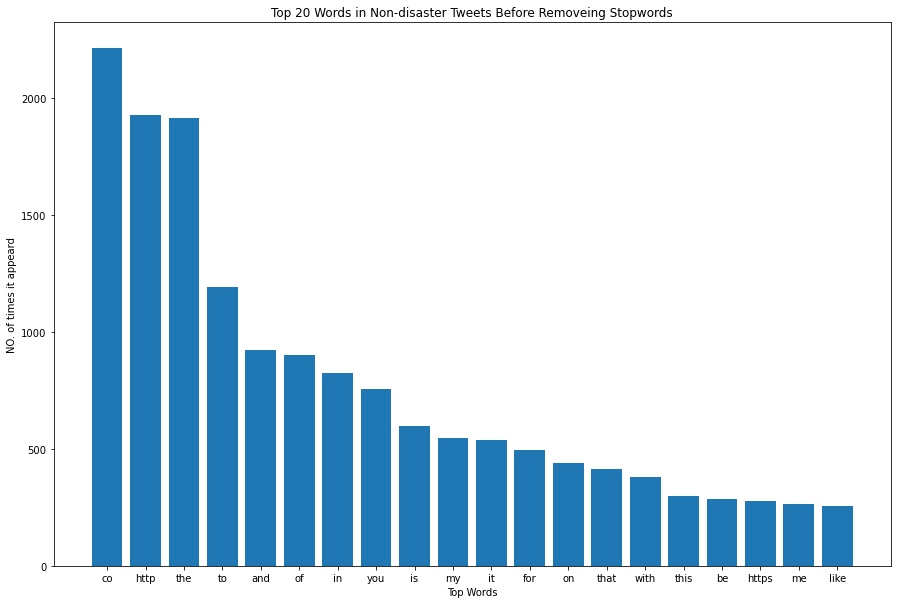

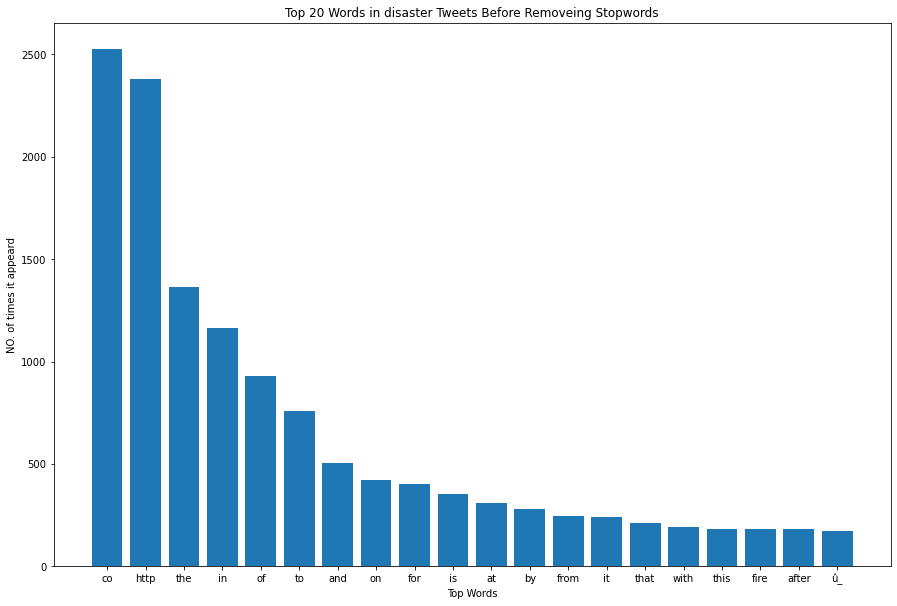

In [7]:
def get_top_n_words_include_stopwords(corpus, n=None, figsize = [15, 10], title = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Create a bar chart to show the top freqs words
    words = []
    freqs = []
    for word, freq in words_freq[:n]:
        words.append(word)
        freqs.append(freq)
    plt.figure(figsize = figsize)
    plt.bar(words, freqs, width = 0.8)
    plt.title('Top {} Words in {} Tweets Before Removeing Stopwords'.format(n, title))
    plt.xlabel("Top Words")
    plt.ylabel("NO. of times it appeard")
    plt.show()
    return words_freq[:n]
# create bar chart to show the top 20 words in non_disaster tweets
non_disaster_tweets = train_df[train_df['target']==0]['text']
topwords_nondisaster = get_top_n_words_include_stopwords(non_disaster_tweets, n=20, title = 'Non-disaster')


# create bar chart to show the top 20 words in disaster tweets
disaster_tweets = train_df[train_df['target']==1]['text']
topwords_disaster = get_top_n_words_include_stopwords(disaster_tweets, n=20, title = 'disaster')

Notice that most of the top words occurs in both datasets are some common stop words and url, such as http, the, in, of, etc. Those stopwords are not good indicators for our model to identify the difference between non-disaster tweets and disaster tweets. 

**Lets remove the stopwords and check again about the most frequently appeared words**

In the following section, I will remove common stopwords in the datasets. However, we noticed that some top words are not commonly considered as regular stopwords, such as **http** and **co**. But **http** and **co** are commonly found in urls, so we need to remove urls in our preprocessing steps later. 

For now, I will include **http** and **co** in the stopwords if they are not included already, so we can remove them and see other top frecrently appeared words in our tweets datasets.

In [8]:
# create a set to contain all top words in our non-disaster tweets and disaster tweets
# then, compare the set of words with our stopwords to check if we need to add anything
words_set = set()
topwords = topwords_nondisaster + topwords_disaster
for word, freq in topwords:
    words_set.add(word)
stop = set(stopwords.words('english'))
## check if our stop words contains some common topwords here:
not_inside = []
for topword in words_set:
    if not topword in stop:
        not_inside.append(topword)
print(not_inside)

['û_', 'like', 'co', 'https', 'fire', 'http']


As we thought earlier, words like **co** and **http** are not included in the **stopwords**, lets include them! 

Since words like **fire**, **like**, **https**, **û_** only appear to be top 20 words on either one of the datasets, we will keep them.

In [9]:
stop.add('co')
stop.add('http')

Now, we can remove the stopwords from our dataset and check again about new topwords appeared in our non-disaster and disaster tweets dataset

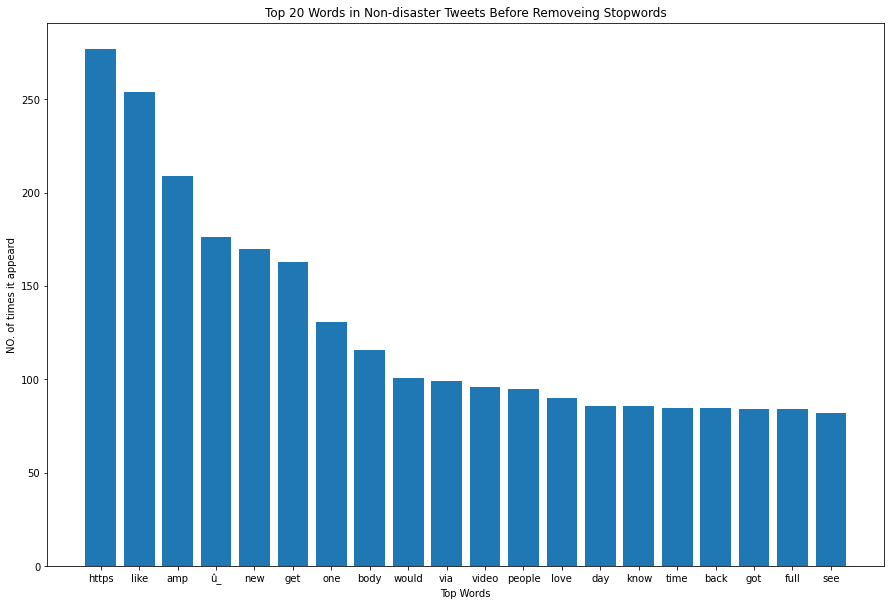

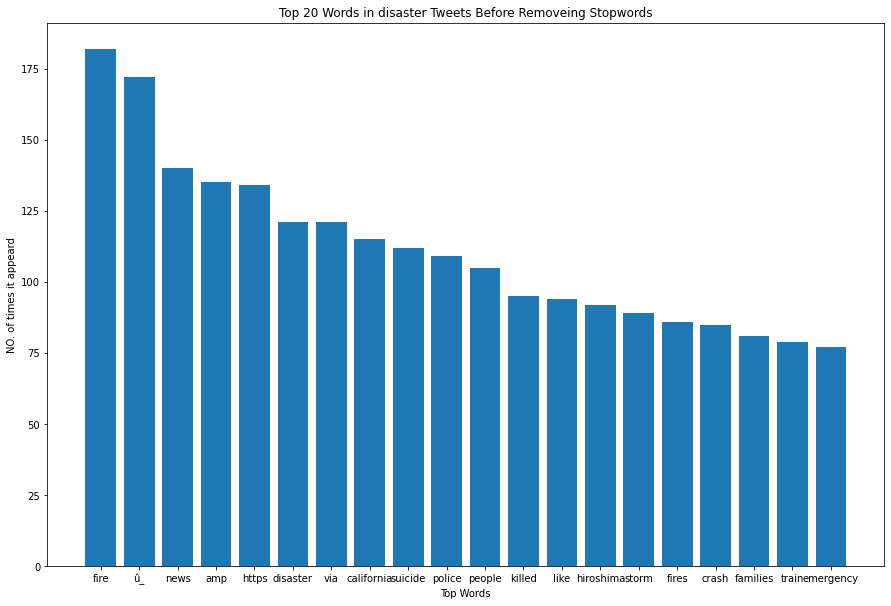

In [10]:
# First remove common stop words
def get_top_n_words_without_stopwords(corpus, n=None, figsize = [15, 10], title = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if (word not in stop)]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    # Create a bar chart to show the top freqs words
    words = []
    freqs = []
    for word, freq in words_freq[:n]:
        words.append(word)
        freqs.append(freq)
    plt.figure(figsize = figsize)
    plt.bar(words, freqs, width = 0.8)
    plt.title('Top {} Words in {} Tweets Before Removeing Stopwords'.format(n, title))
    plt.xlabel("Top Words")
    plt.ylabel("NO. of times it appeard")
    plt.show()
    return words_freq
# create bar chart to show the top 20 words in non_disaster tweets
non_disaster_tweets = train_df[train_df['target']==0]['text']
topwords_nondisaster = get_top_n_words_without_stopwords(non_disaster_tweets, n=20, title = 'Non-disaster')


# create bar chart to show the top 20 words in disaster tweets
disaster_tweets = train_df[train_df['target']==1]['text']
topwords_disaster = get_top_n_words_without_stopwords(disaster_tweets, n=20, title = 'disaster')

If we want, we can add more stopwords to our cleaning process, such as **like**, **https** and **û_**. But I think we are at a good starting point! 

### Lets check whether our non-disaster and disaster tweets have similar amount of puntuations and numbers.

In [11]:
## create corpus from the training dataset
def create_corpus(target):
    corpus = []
    for x in train_df[train_df['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [12]:
def create_barplot(dic1, dic2, figsize = [8,5], title = None):
    # sort the dictionary by the values and create two lists for keys and values
    dic1 = {k: v for k, v in sorted(dic1.items(), key=lambda item:item[1])}
    keys1 = []
    values1 = []
    keys2 = []
    values2 = []
    for key1, value1 in dic1.items():
        keys1.append(key1)
        values1.append(value1)
        keys2.append(key1)
        values2.append(dic2[key1])
    
    # create bar plot 
    X_axis = np.arange(len(keys1))

    fig = plt.figure(figsize = figsize)
    plt.bar(X_axis - 0.2, values1, 0.4, label = 'non-disaster')
    plt.bar(X_axis + 0.2, values2, 0.4, label = 'disaster')
    plt.xticks(X_axis, keys1)
    plt.legend()
    plt.title('Bar plot for {}'.format(title))
    plt.xlabel(title)
    plt.ylabel('No. of times it appeared')
    plt.show()

**First, check the non-disaster tweets, we will create two bar plots to show the frequency of punctuations in the tweets**

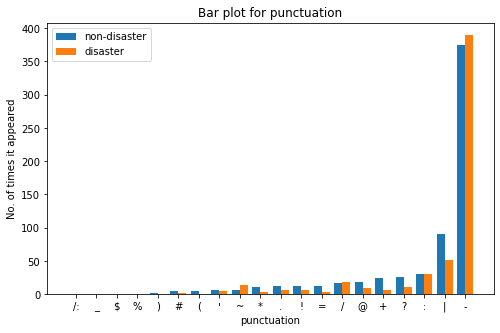

In [13]:
# Note to self: we use collection.defaultdict function to create the dictionary
# If we use regular dict, we nee to make sure the key already exists in the dict
punc = string.punctuation
## first, lets check non-disaster tweets
corpus0 = create_corpus(0)
punc_dict0 = defaultdict(int)
for i in corpus0:
    if i in punc:
        punc_dict0[i] += 1

corpus1 = create_corpus(1)
punc_dict1 = defaultdict(int)

for i in corpus1:
    if i in punc:
        punc_dict1[i] += 1

create_barplot(punc_dict0, punc_dict1, title = 'punctuation')

In the bar chart, I cannot see any sign that any punctuation will help us to differentiate non-disaster and disaster tweets. I will remove the punctuation in our datasets in the preprocessing steps. 

**Now, lets check the usage of numbers in two different tweets.**

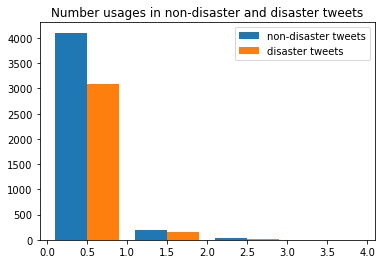

In [14]:
nums = string.digits
## count NO. of numbers appeared in a tweet of a dataset
def countnum(target):
    tweets = train_df[train_df['target']==target]['text'].values
    counts = []
    for i in range(tweets.shape[0]):
        count = 0
        tweet_words = tweets[i].split() # a list that contains all words in a tweet
        for word in tweet_words:
            if word in nums:
                count += 1
        counts.append(count)
    return counts
count0 = countnum(0)
count1 = countnum(1)
## create histogram to show the number usages in non-disaster and disaster tweets datasets
plt.figure()
plt.hist([count0, count1], 4, label = ['non-disaster tweets', 'disaster tweets'])
plt.title('Number usages in non-disaster and disaster tweets')
plt.legend()
plt.show()

As we can see from the above histogram, non-disaster tweets tend to use numbers more in their sentences. In my opinion, the number could be considered as a good features to keep to seperate non-disaster and disaster tweets.

## Preprocessing the datasets for model training

In this notebook, I cleaned the text dataset by lowering letter case, removing stopwords, the urls, html tages, emoji, and punctuations. 

For preprocess step, we will convert the text to vectors, and create our embedding layer based on pre trained package **Glove**. 

In [15]:
## First, concat training and testing dataframe, we want to have the same preprocess on our messages for both datasets
df = pd.concat([train_df, test_df])
df.shape

(10876, 5)

**Create some sub functions to our preprocess/cleaning steps**

In [16]:
# remove urls
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# remove HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
# remove emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove punctuations
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

**We can consider to have spell checker for our tweets data, but note that the spell checker code would be time consuming**

In [17]:
## correct spelling using pyspellchecker
!pip install pyspellchecker
from spellchecker import SpellChecker
def correct_spellings(text):
    corrected_text = []
    misspelled_words = SpellChecker().unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(SpellChecker().correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
text = "corect me plese"

In [18]:
## Use this preprocessing function to decide what cleaning steps we want 
def preprocessing(text):
    text = remove_url(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = remove_punct(text)
    return text

In [19]:
# applying the cleaning process for our text data
df['text'] = df['text'].apply(lambda x: preprocessing(x))

In [20]:
# we can decide to run this code or not based on our time line
# df['text'] = df['text'].apply(lambda x: correct_spellings(x))

Lets check out the output after we preprocessed our text datasets

In [21]:
df['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane My citya...
3260                    Green Line derailment in Chicago 
3261            MEG issues Hazardous Weather Outlook HWO 
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 10876, dtype: object

Not so bad! We noticed that we have donw things that we want to complish in our data cleaning steps.

**Coming next, we need to convert our corpus to vectors, so we can use numerical values to represent every tweets.**

In [22]:
# stop = set(stopwords.words('english'))
# ## create corpus from the dataframe
# def create_corpus(df):
#     corpus = []
#     for tweet in df['text']:
#         for word in word_tokenize(tweet):
#             if word not in stop:
#                 corpus.append(word.lower())
#     return corpus

In [23]:
stop = set(stopwords.words('english'))
def create_corpus(df):
    corpus = []
    for tweet in df['text']:
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() ==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [24]:
corpus = create_corpus(df)
len(corpus)

10876

In [25]:
## since the maximum of number of words used in each tweet are less than 30, we will set maxlen to 50 to avoid truncat any tweets.
corpus = create_corpus(df)
maxlen = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen = maxlen, truncating = 'post', padding = 'post')
word_index = tokenizer_obj.word_index
print(len(word_index))

20342


In [26]:
def create_embedding(embedding_dimension, word_index = word_index, source_path = False):
    # use this function to create embedding layer with given string: embedding dimension and tokenizers: word_index 
    # output is the embedding layer for the given embedding dimension
    embedding_dict = {}
    glove_filename = 'glover/glove.6B.'+ embedding_dimension +'d.txt'
    with open(glove_filename, 'r',encoding = 'utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()
    
    # create embedding matrix with pre trained glove file
    num_words = len(word_index)+1
    embedding_matrix = np.zeros((num_words, int(embedding_dimension)))
    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
        embedding_layer = Embedding(num_words, int(embedding_dimension), embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False)
    print('Embedding layer created!')
    return embedding_layer

In [27]:
def create_lstm(num_neurons, bidir):
    if bidir == True:
        return Bidirectional(LSTM(num_neurons, dropout = 0.2, recurrent_dropout = 0.2))
    else:
        return LSTM(num_neurons, dropout = 0.2, recurrent_dropout = 0.2)

In [28]:
# create training and validation datasets for our model training phrase
train = tweet_pad[:train_df.shape[0]]
test = tweet_pad[train_df.shape[0]:]
test_size = 0.1
train_X, val_X, train_y, val_y = train_test_split(train, train_df['target'].values, test_size = test_size)
print(train_X.shape)
print(val_X.shape)

(6851, 50)
(762, 50)


Time to build the models! (My favorite part😃!)

## Building pipeline for model comparision

In [29]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [30]:
## create submission file
def sub_csv(model, model_num, test):
    ## predict the test vectors
    sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
    sample_submission["target"] = [1 if i >=0.5 else 0 for i in model.predict(test)]
    sample_submission.to_csv("submission{}.csv".format(model_num), index = False)
    print("# {} submission file created!".format(model_num))

In [31]:
def create_pipelines(verbose = 1):
    # initialize different layers for the deep learning models:
    # including: embedding layer; LSTM layer; Dense layer; 
    # Also include different optimizers: Adam; RMSprop
    embedding_dimensions = ['200']
    lstm_setups = [(64, True), (64, False)]
    optimizers = [Adam(learning_rate = 1e-5), RMSprop(learning_rate = 1e-5)]
    pipelines = []
    for embedding_dimension in embedding_dimensions:
        embedding_layer = create_embedding(embedding_dimension)
        for lstm_setup in lstm_setups:
            lstm_neuron = lstm_setup[0]
            lstm_bidir = lstm_setup[1]
            lstm_layer = create_lstm(lstm_neuron, lstm_bidir)
            for i in range(len(optimizers)):
                model_name = 'embed_dimension'+embedding_dimension+'_lstm (' + str(lstm_neuron)+', '+str(lstm_bidir) + ')_'
                if i == 0:
                    model_name += 'Adam'
                else:
                    model_name += 'RMSprop'
                pipeline = ([embedding_layer, lstm_layer, optimizers[i]], model_name)
                pipelines.append(pipeline)
    return pipelines
            
    

In [32]:
# pipelines = create_pipelines()

In [33]:
# len(pipelines)

In [34]:
# ## build deep learning model from the pipelines
# for i in range(len(pipelines)):
#     model_num = 'model'+str(i)
#     pipeline = pipelines[i]
#     embedding = pipeline[0][0]
#     lstm = pipeline[0][1]
#     optimizer = pipeline[0][2]
#     model_name = pipeline[1]
    
#     ## create the model
#     locals()[model_num] = tf.keras.Sequential()
#     locals()[model_num].add(embedding)
#     locals()[model_num].add(SpatialDropout1D(0.2))
#     locals()[model_num].add(lstm)
#     locals()[model_num].add(Dense(1, activation = 'sigmoid'))
#     locals()[model_num].compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

## Choose what are good options for our model architecture by runing experiences with different models
### Run the code in the below to train the total 4 models:
* different LSTM layer (bidirection or not)
* different optimizers (Adam or RMSprop). 

We skiped the following code in this notebook to reduce running time. I have previouly run the code and found the best performance is the model3.

**We can add more models by changing embedding layer, Dense layer, etc. But remember that the more models are trained, the longer time it takes to run.**

In [35]:
## training models with given data
# num_epochs = 15
# histories = []
# for i in range(len(pipelines)):
#     model = locals()['model'+str(i)]
#     history = model.fit(train_X, train_y, epochs = num_epochs, validation_data = (val_X, val_y))
#     histories.append(history)
#     plot_graph(history, "accuracy")
#     plot_graph(history, "loss")
#     sub_csv(model, i,test)

### Since we found that model3 has the best training performance, I will increase the number of epochs for my model3 training.

In [36]:
# pipelines[3]

In [37]:
# model3.summary()

In [38]:
# num_epochs = 70
# history = model3.fit(train_X, train_y, epochs = num_epochs, validation_data = (val_X, val_y))
# plot_graph(history, "accuracy")
# plot_graph(history, "loss")
# sub_csv(model3, 3,test)

In [39]:
## try embedding dimension with 200D, and bidirectional lstm layer
model = tf.keras.Sequential()
model.add(create_embedding('200',source_path = True))
model.add(SpatialDropout1D(0.2))
model.add(create_lstm(64, True))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(learning_rate = 1e-5), metrics = ['accuracy'])
model.summary()

100%|██████████████████████████████████████████████████████████████████████████| 20342/20342 [00:09<00:00, 2048.77it/s]


Embedding layer created!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20341 (Embedding)  (None, 50, 200)           4068600   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,204,409
Trainable params: 135,809
Non-trainable params: 4,068,600
_________________________________________________________________


Epoch 1/40
215/215 [==============================] - 44s 204ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 2/40
215/215 [==============================] - 43s 199ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 3/40
215/215 [==============================] - 44s 203ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 4/40
215/215 [==============================] - 44s 205ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 5/40
215/215 [==============================] - 44s 206ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 6/40
215/215 [==============================] - 52s 243ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 7/40
215/215 [==============================] - 54s 252ms/step - loss: nan - accuracy: 0.5687 - val_loss: nan - val_accuracy: 0.5853
Epoch 8/40
215/215 [=======

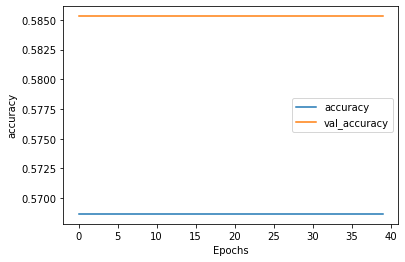

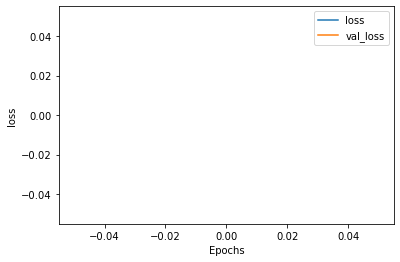

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/nlp-getting-started/sample_submission.csv'

In [40]:
num_epochs = 40
history = model.fit(train_X, train_y, epochs = num_epochs, validation_data = (val_X, val_y))
plot_graph(history, "accuracy")
plot_graph(history, "loss")
sub_csv(model, 4,test)